In [1]:
import openai
from openai.types import Completion, CompletionChoice, CompletionUsage
import os
import requests
from dotenv import load_dotenv
from scipy.optimize import minimize, Bounds, NonlinearConstraint
from functools import partial 

load_dotenv("/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/hidden.env")
%reload_ext autoreload
from Setup_Functions import *
from Class_Structures import *
from Region import * 
from Individual import * 
from Pairwise import * 

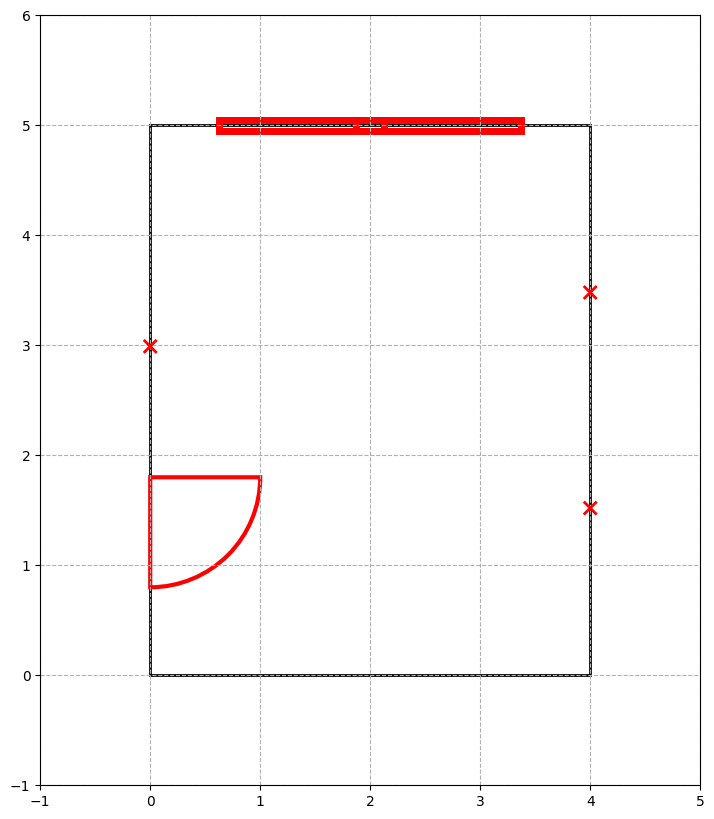

New best result found. Cost:  9.467630842597371
New best result found. Cost:  3.9850984427414837
New best result found. Cost:  3.985098309913748


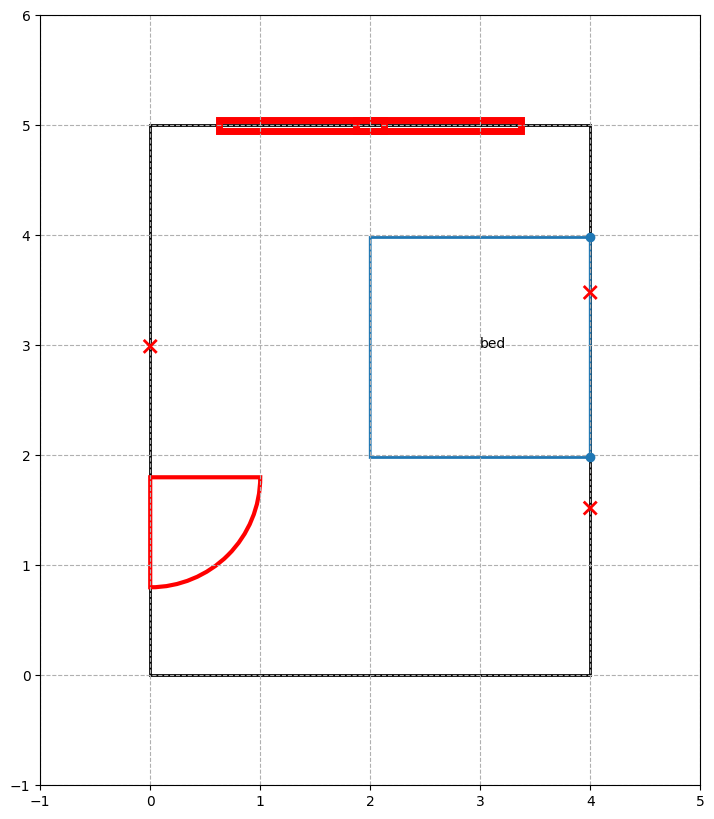

0.0016625621827387124 0.03646749712431336
New best result found. Cost:  2.51055890531103 overlap:  0.0018294865353670443 bounds:  2.630398563825594e-08
0.0012957996752652342 0.037113498238667095
New best result found. Cost:  1.235197857130252 overlap:  0 bounds:  1.3114497628898877e-06


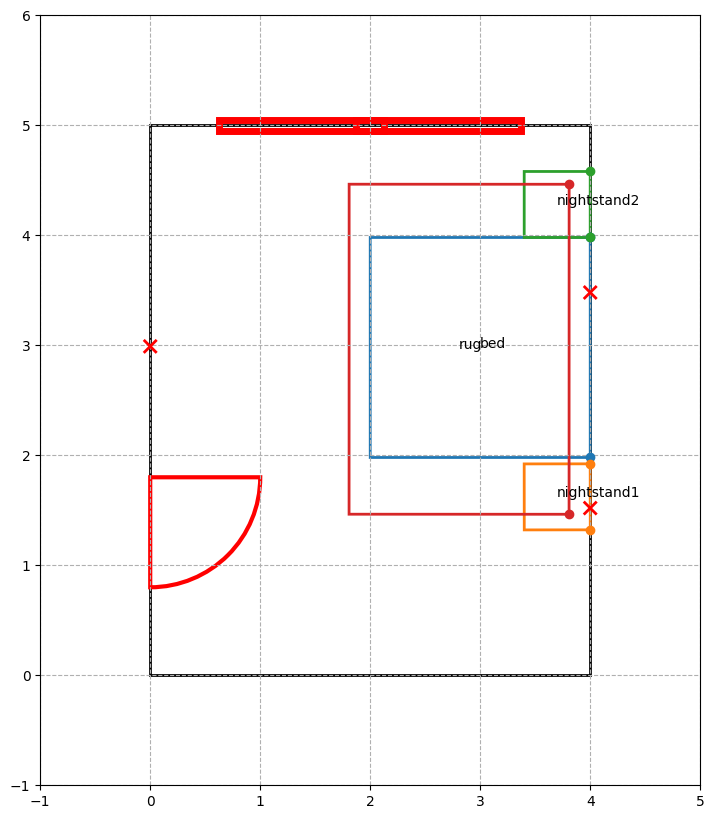

In [4]:
room = create_room(4, 5)
create_fixed_object(room, 'window', 1.5, 0.1, 'north', position = 0.25)
create_fixed_object(room, 'window', 1.5, 0.1, 'north', position = 0.75)
create_fixed_object(room, 'door', 1, 0.1, 'west', position = 0.2)
create_fixed_object(room, 'socket', 0.1, 0.05, 'west', position = 0.6)
create_fixed_object(room, 'socket', 0.1, 0.05, 'east', position = 0.3)
create_fixed_object(room, 'socket', 0.1, 0.05, 'east', position = 0.7)
room.draw()

options = {'maxiter': 300, 'ftol': 1e-6}
sleep = region_setup(room, 'sleeping', 0)
create_moving_object(room, 'bed', 2, 2, 'sleeping', 0)

def optimize_primary_objects(positions, room): 
    
    output = 0
    output += ind_next_to_wall(positions, room, 0, 'back')  # bed
    output += ind_close_to_fixed_object(positions, room, 0, 'socket', side = 'back')
    output += ind_away_from_fixed_object(positions, room, 0, 'window')
    output += ind_away_from_fixed_object(positions, room, 0, 'door')
    output += ind_central(positions, room, 0)
    output += ind_accessible(positions, room, 0, ['left', 'front'])  # bed
    output += ind_aligned(positions, room)
    output += ind_no_overlap(positions, room)
    output += ind_in_bounds(positions, room)

    return output

iters = 0
min_fun = np.Inf
while min_fun > 1e-2 and iters < 50:
    positions = np.zeros(3*len(room.moving_objects))
    for i in range(len(room.moving_objects)):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_primary_objects, positions, args = (room), method = 'SLSQP', options = options) 
    iters += 1
    if res.fun < min_fun:
        if not ind_no_overlap(res.x, room) > 0.4 and not ind_in_bounds(res.x, room) > 0.4:
            min_fun = res.fun
            best_res = res
            print("New best result found. Cost: ", min_fun)

    
for i in range(len(room.moving_objects)): 
    room.moving_objects[i].position = best_res.x[3*i:3*i + 3] 
room.draw() 

room.regions[0].x, room.regions[0].y = room.moving_objects[0].position[0], room.moving_objects[0].position[1]
prev_cost = min_fun 

room.fm_indices += [0]

create_moving_object(room, 'nightstand1', 0.6, 0.6, 'sleeping', 1)
create_moving_object(room, 'nightstand2', 0.6, 0.6, 'sleeping', 2)
create_moving_object(room, 'rug', 3, 2, 'sleeping', 3)

def optimize_secondary_objects(positions, room):
    output = 0
    output += 0.2*optimize_primary_objects(positions, room)

    output += ind_next_to_wall(positions, room, 1, 'back')  # nightstand1
    output += ind_next_to_wall(positions, room, 2, 'back')  # nightstand2
    output += p_between(positions, room, 0, 1, 2)  # nightstand1, nightstand2
    output += ind_accessible(positions, room, 1, ['front'])  # nightstand1
    output += p_next_to(positions, room, 1, 0, 'right', 'left')  # nightstand1, bed
    output += ind_accessible(positions, room, 2, ['front'])  # nightstand2

    output += p_under_central(positions, room, 3, 0) # rug, bed
    output += ind_not_against_wall(positions, room, 3) # rug

    output += ind_in_region(positions, room, 1, 'sleeping')
    output += ind_in_region(positions, room, 2, 'sleeping')
    output += ind_in_region(positions, room, 3, 'sleeping')

    output += ind_aligned(positions, room)
    output += ind_no_overlap(positions, room)
    output += ind_in_bounds(positions, room)

    return output

num = len(room.moving_objects) - len(room.fm_indices)
bounds = bounds = Bounds([-10] * 3 * num, [room.width + 10, room.length + 10, np.Inf] * num)
iters = 0
min_fun = np.Inf
while min_fun > 5e-2 and iters < 50:
    positions = np.zeros(3*num)
    for i in range(num):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_secondary_objects, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)
    iters += 1
    if res.fun < min_fun:
        if not ind_no_overlap(res.x, room) > 1e-2 and not ind_in_bounds(res.x, room) > 0.4:
            min_fun = res.fun 
            best_res = res
            print("New best result found. Cost: ", min_fun, "overlap: ", ind_no_overlap(res.x, room), "bounds: ", ind_in_bounds(res.x, room))
    
for i in range(len(room.fm_indices), len(room.moving_objects)): 
    index = i - len(room.fm_indices)
    room.moving_objects[i].position = best_res.x[3*index:3*index + 3] 
room.draw() 

room.regions[0].x = np.mean([i.position[0] for i in room.moving_objects if i.region == 'sleeping'])
room.regions[0].y = np.mean([i.position[1] for i in room.moving_objects if i.region == 'sleeping'])

room.fm_indices += [i for i in range(len(room.fm_indices), len(room.moving_objects))]
prev_cost = min_fun 

New best result found. Cost:  13.213411825063218 overlap:  0 bounds:  0.00011461381238894997
New best result found. Cost:  13.213411151737484 overlap:  0 bounds:  0.00011461380977030606
New best result found. Cost:  13.213407107702551 overlap:  0 bounds:  0.00011461380043791112


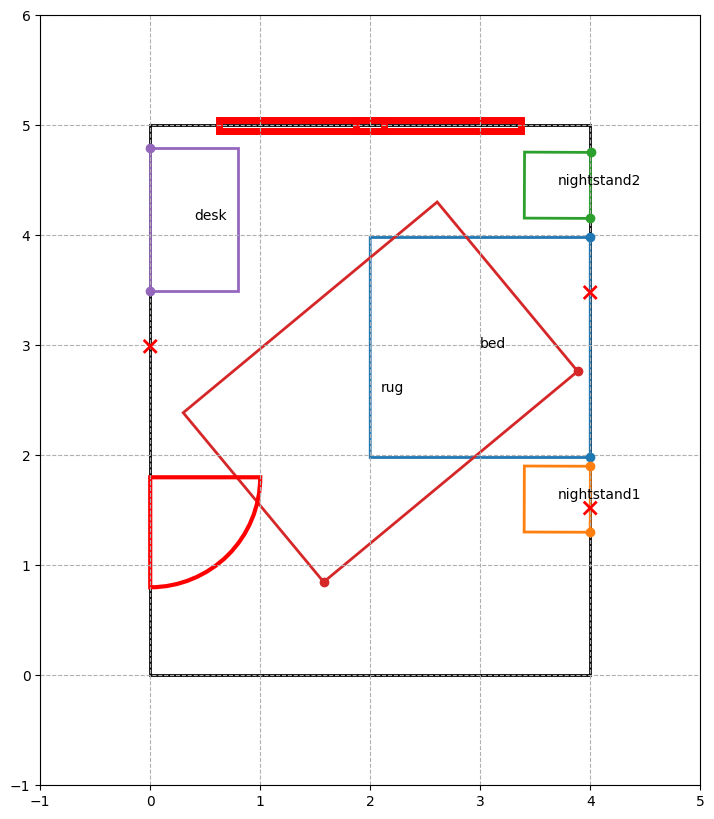

New best result found. Cost:  12.771192887350699 overlap:  0 bounds:  0.00011461380043791112
New best result found. Cost:  12.683037294556812 overlap:  0 bounds:  0.00011461380043791112


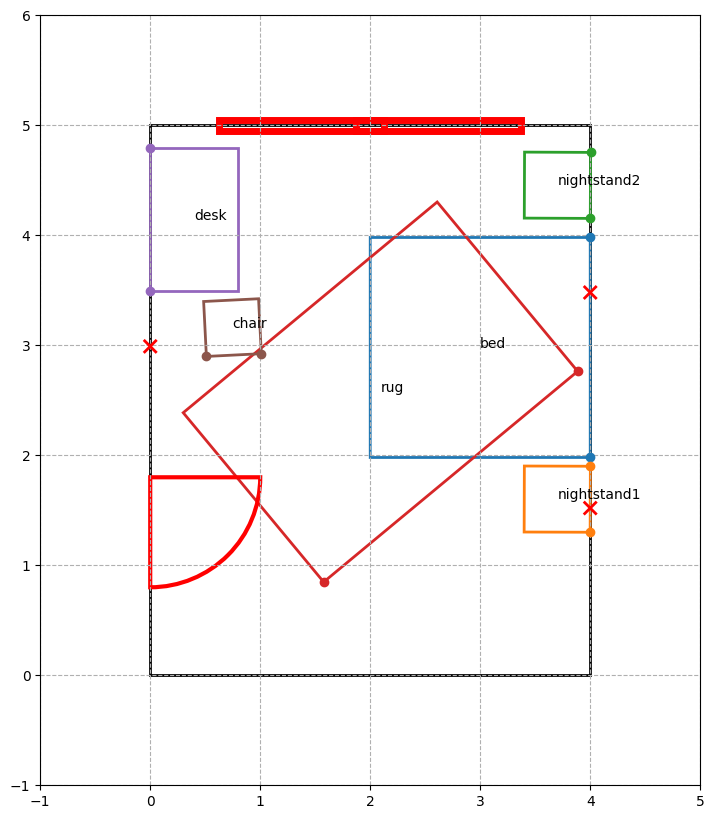

In [9]:
## Region 2
working = region_setup(room, 'working', 1)
create_moving_object(room, 'desk', 1.3, 0.8, 'working', 4)

def optimize_primary_objects2(positions, room):
    output = 0
    output += ind_accessible(positions, room, 0, ['left', 'front'])  # bed
    output += ind_accessible(positions, room, 1, ['front'])  # nightstand1
    output += ind_accessible(positions, room, 2, ['front'])  # nightstand2
    
    output += ind_next_to_wall(positions, room, 4, 'back')  # desk
    output += ind_close_to_fixed_object(positions, room, 4, 'socket')
    output += ind_close_to_fixed_object(positions, room, 4, 'window')
    output += p_away_from(positions, room, 4, 0)  # desk, bed

    output += ind_aligned(positions, room)
    output += ind_no_overlap(positions, room)
    output += ind_in_bounds(positions, room)

    return output

num = len(room.moving_objects) - len(room.fm_indices)
bounds = bounds = Bounds([-10] * 3 * num, [room.width + 10, room.length + 10, np.Inf] * num)
iters = 0
min_fun = np.Inf
while min_fun > 1e-2 and iters < 30:
    positions = np.zeros(3*num)
    for i in range(num):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_primary_objects2, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)
    iters += 1
    if res.fun < min_fun:
        if not ind_in_bounds(res.x, room) > 0.3:
            min_fun = res.fun 
            best_res = res
            print("New best result found. Cost: ", min_fun, "overlap: ", ind_no_overlap(res.x, room), "bounds: ", ind_in_bounds(res.x, room))
    
for i in range(len(room.fm_indices), len(room.moving_objects)): 
    index = i - len(room.fm_indices)
    room.moving_objects[i].position = best_res.x[3*index:3*index + 3] 
room.draw() 

room.regions[1].x, room.regions[1].y = room.moving_objects[4].position[0], room.moving_objects[4].position[1]
prev_cost = min_fun

room.fm_indices += [4]
create_moving_object(room, 'chair', 0.5, 0.5, 'working', 5)

def optimize_secondary_objects2(positions, room):

    output = 0
    output += ind_accessible(positions, room, 0, ['left', 'front'])  # bed
    output += ind_accessible(positions, room, 1, ['front'])  # nightstand1
    output += ind_accessible(positions, room, 2, ['front'])  # nightstand2

    output += p_next_to(positions, room, 5, 4, 'front', 'front')
    output += ind_in_region(positions, room, 5, 'working')

    output += ind_aligned(positions, room)
    output += ind_no_overlap(positions, room)
    output += ind_in_bounds(positions, room)

    return output 

num = len(room.moving_objects) - len(room.fm_indices)
bounds = bounds = Bounds([-10] * 3 * num, [room.width + 10, room.length + 10, np.Inf] * num)
iters = 0
min_fun = np.Inf
while min_fun > 1e-2 and iters < 30:
    positions = np.zeros(3*num)
    for i in range(num):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_secondary_objects2, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)
    iters += 1
    if res.fun < min_fun:
        min_fun = res.fun 
        best_res = res
        print("New best result found. Cost: ", min_fun, "overlap: ", ind_no_overlap(res.x, room), "bounds: ", ind_in_bounds(res.x, room))
    
for i in range(len(room.fm_indices), len(room.moving_objects)): 
    index = i - len(room.fm_indices)
    room.moving_objects[i].position = best_res.x[3*index:3*index + 3] 
room.draw() 
prev_cost = 1.0 * min_fun 

room.regions[1].x = np.mean([i.position[0] for i in room.moving_objects if i.region == 'working'])
room.regions[1].y = np.mean([i.position[1] for i in room.moving_objects if i.region == 'working'])

room.fm_indices += [5]

New best result found. Cost:  15.188429478000254 overlap:  0 bounds:  0.15354765172868348


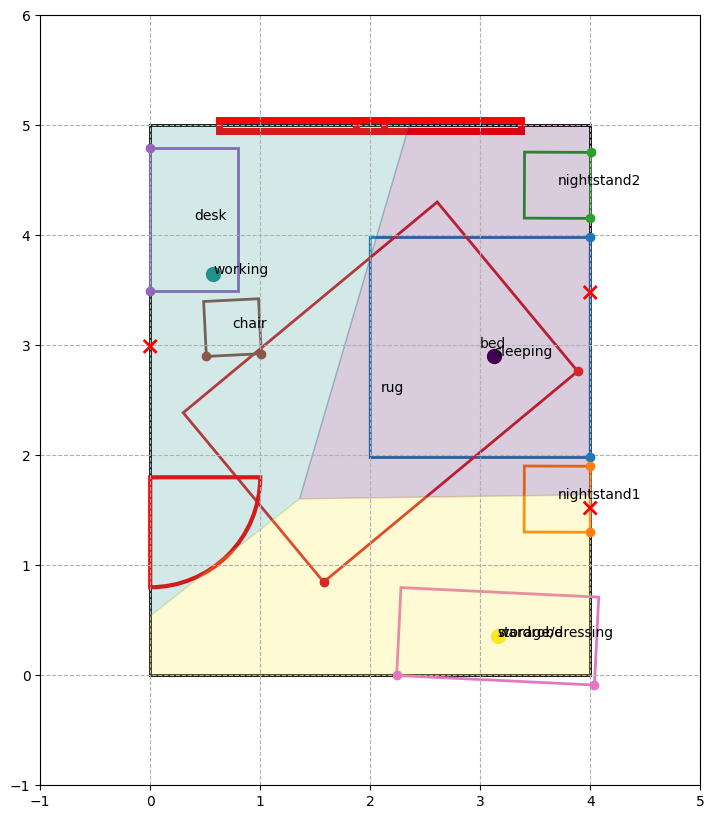

New best result found. Cost:  14.423305285815198 overlap:  0 bounds:  0.1535476517293973


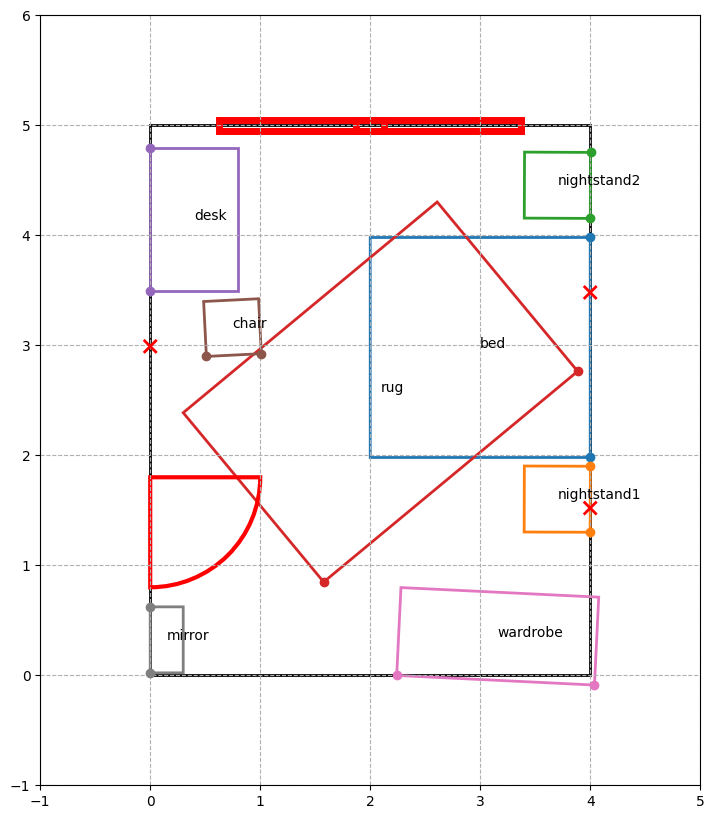

In [10]:
## Region 3

options = {'maxiter': 150, 'ftol': 1e-5}
storage = region_setup(room, 'storage/dressing', 2)
create_moving_object(room, 'wardrobe', 1.8, 0.8, 'storage/dressing', 6)

def optimize_primary_objects3(positions, room):
    output = 0

    output += ind_accessible(positions, room, 0, ['left', 'front'])  # bed
    output += ind_accessible(positions, room, 1, ['front'])  # nightstand1
    output += ind_accessible(positions, room, 2, ['front'])  # nightstand2
    
    output += ind_next_to_wall(positions, room, 6, 'back')  # wardrobe
    output += ind_accessible(positions, room, 6, ['front'])
    output += ind_not_block_fixed_object(positions, room, 6, 'window')

    output += p_away_from(positions, room, 6, 0)  # wardrobe, bed
    output += p_away_from(positions, room, 6, 4)  # wardrobe, desk

    output += ind_aligned(positions, room)
    output += ind_no_overlap(positions, room)
    output += ind_in_bounds(positions, room)

    return output

num = len(room.moving_objects) - len(room.fm_indices)
bounds = bounds = Bounds([-10] * 3 * num, [room.width + 10, room.length + 10, np.Inf] * num)
iters = 0
min_fun = np.Inf
while min_fun > 1e-2 and iters < 30:
    positions = np.zeros(3*num)
    for i in range(num):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_primary_objects3, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)
    iters += 1
    if res.fun < min_fun:
        if not ind_in_bounds(res.x, room) > 0.3:
            min_fun = res.fun 
            best_res = res
            print("New best result found. Cost: ", min_fun, "overlap: ", ind_no_overlap(res.x, room), "bounds: ", ind_in_bounds(res.x, room))

for i in range(len(room.fm_indices), len(room.moving_objects)): 
    index = i - len(room.fm_indices)
    room.moving_objects[i].position = best_res.x[3*index:3*index + 3] 

room.regions[2].x, room.regions[2].y = room.moving_objects[6].position[0], room.moving_objects[6].position[1]
room.draw(draw_regions = True) 
prev_cost = min_fun

room.fm_indices += [6]
create_moving_object(room, 'mirror', 0.6, 0.3, 'storage/dressing', 7)

def optimize_secondary_objects3(positions, room):

    output = 0
    output += ind_accessible(positions, room, 0, ['left', 'front'])  # bed
    output += ind_accessible(positions, room, 1, ['front'])  # nightstand1
    output += ind_accessible(positions, room, 2, ['front'])  # nightstand2
    output += ind_accessible(positions, room, 6, ['front'])  # wardrobe

    output += ind_in_region(positions, room, 7, 'storage/dressing')
    output += ind_next_to_wall(positions, room, 7, 'back')  # mirror
    output += ind_accessible(positions, room, 7, ['front'])
    output += ind_aligned(positions, room)
    output += ind_no_overlap(positions, room)
    output += ind_in_bounds(positions, room)
    output += p_not_facing(positions, room, 7, 0)
    output += ind_not_block_fixed_object(positions, room, 7, 'window')

    return output 

num = len(room.moving_objects) - len(room.fm_indices)
bounds = bounds = Bounds([-10] * 3 * num, [room.width + 10, room.length + 10, np.Inf] * num)
iters = 0
min_fun = np.Inf
while min_fun > 1e-2 and iters < 30:
    positions = np.zeros(3*num)
    for i in range(num):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_secondary_objects3, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)
    iters += 1
    if res.fun < min_fun:
        if not ind_in_bounds(res.x, room) > 0.3:
            min_fun = res.fun 
            best_res = res
            print("New best result found. Cost: ", min_fun, "overlap: ", ind_no_overlap(res.x, room), "bounds: ", ind_in_bounds(res.x, room))
    
for i in range(len(room.fm_indices), len(room.moving_objects)): 
    index = i - len(room.fm_indices)
    room.moving_objects[i].position = best_res.x[3*index:3*index + 3] 

room.draw() 


room.regions[2].x = np.mean([i.position[0] for i in room.moving_objects if i.region == 'storage/dressing'])
room.regions[2].y = np.mean([i.position[1] for i in room.moving_objects if i.region == 'storage/dressing'])
room.fm_indices += [7]

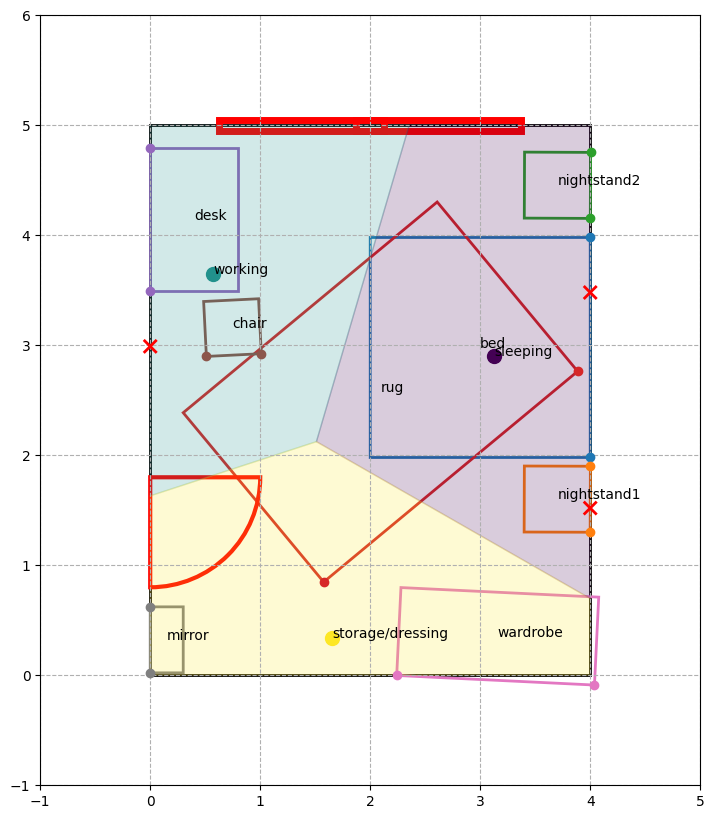

In [11]:
room.draw(draw_regions = True)

In [12]:
for i in range(len(room.moving_objects)):
    print(room.moving_objects[i].name, room.moving_objects[i].position)

bed [2.99999609 2.98000636 7.85397583]
nightstand1 [3.70027472 1.60134818 1.56751455]
nightstand2 [3.70181195 4.4547488  1.56649289]
rug [2.09283175 2.5751421  6.97575899]
desk [0.4000001  4.1400001  4.71238874]
chair [0.74778605 3.16075049 6.33328678]
wardrobe [3.15897764 0.35428882 6.23479588]
mirror [0.15000073 0.32212179 4.71239231]
